# Calibrating resnet on CIFAR10 test set

In [1]:
import os
import sys
import time
import collections
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input

from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, accuracy, empirical_cross_entropy
from utils.visualization import plot_pdf_triplex, plot_prob_triplex, reliability_plot
from utils.data import get_cifar10
from flows.nice import NiceFlow
from calibrators import PAVCalibrator, NiceCalibrator, TempScalingCalibrator, MLRCalibrator

In [2]:
%matplotlib inline

## Load CIFAR10 test-set

In [3]:
data_path = '../cifar-10'

In [4]:
cifar10, ix2label = get_cifar10(data_path, test=True)
print("Number of samples in the test set: {:d}".format(cifar10["test_labels"].shape[0]))

Number of samples in the test set: 10000


As part of the preprocessing, resnet models normalize to 1 and subtract the mean of the training set:

In [5]:
X_train = cifar10['test_images']/255.
train_mean = np.mean(X_train, axis=0)

X_test = cifar10['test_images']/255.- train_mean
y_test = onehot_encode(cifar10['test_labels'])

Check how classes are distributed:

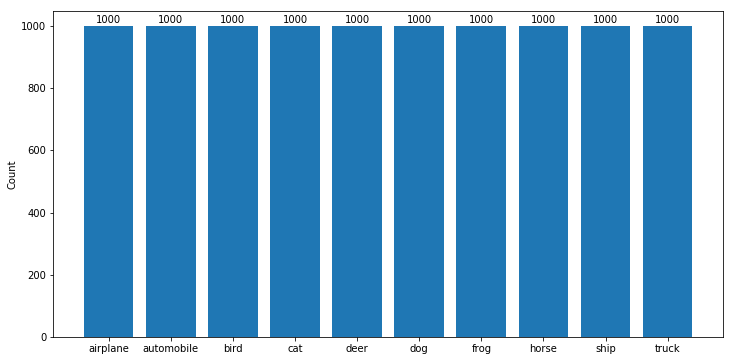

In [6]:
label_counter = collections.Counter(cifar10["test_labels"])

f, ax = plt.subplots(figsize=(12,6))
plt.bar(label_counter.keys(), label_counter.values(), tick_label=[ix2label[k] for k in label_counter.keys()]);
ax.set_ylabel('Count');

rects = ax.patches

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(height),
            ha='center', va='bottom')

## Load model

In [7]:
resnet_path = '../pretrained-models'
net = 'resnet56v2.h5'
model = tf.keras.models.load_model(os.path.join(resnet_path, net), custom_objects={'tf': tf})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Visualize some predictions:

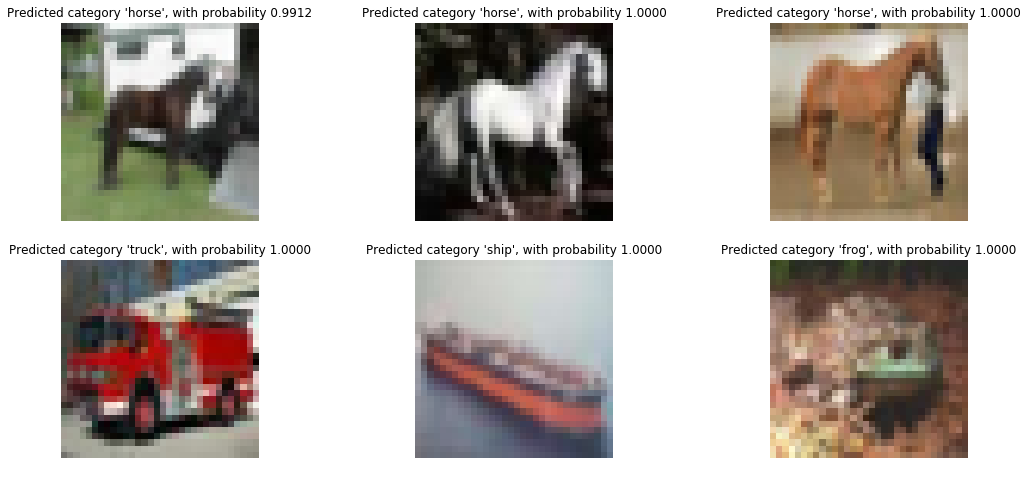

In [8]:
idxs = [20, 13, 543, 23, 999, 2304]

fig, ax_arr = plt.subplots(2, 3, figsize=(18, 8))


for i, idx in enumerate(idxs):
    test_ima = X_test[idx, :]
    probs = model.predict(test_ima[np.newaxis, :])
    pred = np.argmax(probs)
    ax_arr[i//3, i%3].imshow(cifar10['test_images'][idx]/255.)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted category '{}', with probability {:.4f}".format(ix2label[pred], probs[0][pred]))
    
plt.show();

### Compute NLL of the classifier on the test set 

In [9]:
probs = model.predict(X_test, batch_size=100)

In [10]:
base_nll = neg_log_likelihood(probs, y_test)
base_acc = accuracy(probs, y_test)

In [11]:
print("Negative log-likelihood of the classifier on the test set: {:.3f}".format(base_nll))
print("Accuracy of the classifier on the test set: {:.3f}".format(base_acc))

Negative log-likelihood of the classifier on the test set: 0.297
Accuracy of the classifier on the test set: 0.933


# Calibrating the network

First we need to obtain the logits instead of the final probabilities

In [12]:
logit_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [13]:
logits = logit_model.predict(X_test, batch_size=100)

## Temperature scaling calibration:

In [14]:
# Temp scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, y_test)
print("Optimal temperature found: {:.3f}, elapsed time: {:.3f}s".format(temp_cal.T, (time.time()-t0)))
temp_probs = temp_cal.predict(logits)

temp_nll = neg_log_likelihood(temp_probs, y_test)
temp_acc = accuracy(temp_probs, y_test)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(temp_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(temp_acc))

Optimal temperature found: 2.388, elapsed time: 1.341s
Negative log-likelihood after calibration with temp-scaling: 0.197
Accuracy after calibration with temp-scaling: 0.933


Effect on the probabilities

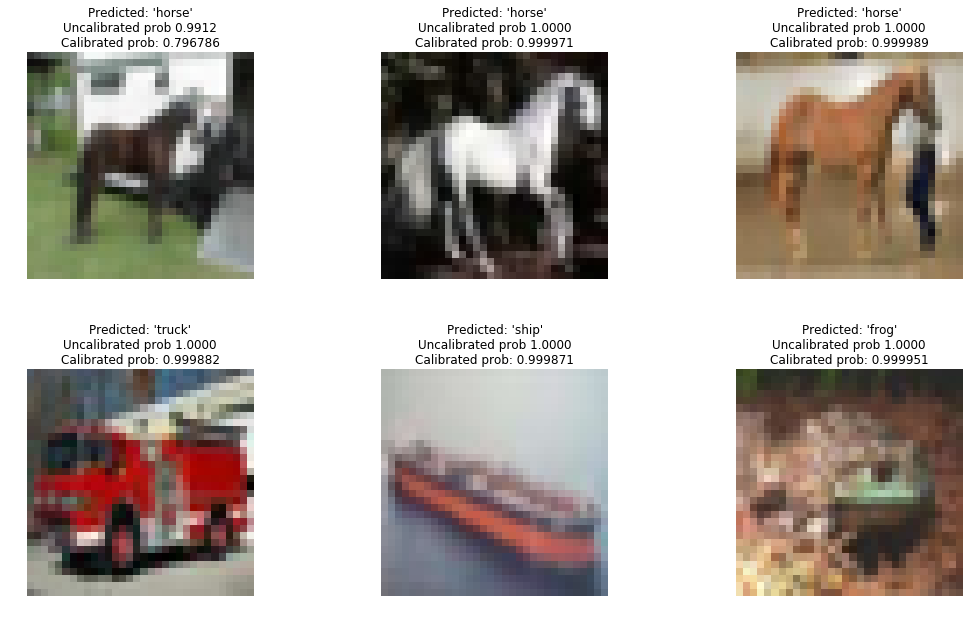

In [15]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4})


for i, idx in enumerate(idxs):
    test_ima = cifar10['test_images'][idx]/255.
    pred = np.argmax(probs[idx])
    ax_arr[i//3, i%3].imshow(test_ima)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted: '{}'\nUncalibrated prob {:.4f}\nCalibrated prob: {:4f}".format(ix2label[pred], probs[idx][pred], temp_probs[idx][pred]))
    
plt.show();

## Calibrate with PAV extended to multiclass(normalization):

In [16]:
t0 = time.time()
pav_cal = PAVCalibrator(logits.astype(np.float), y_test.astype(np.float))
print("PAV calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

PAV calibration fitted, elapsed time: 0.074s


In [17]:
pav_probs = pav_cal.predict(logits.astype(np.float))

pav_nll = neg_log_likelihood(pav_probs, y_test)
pav_acc = accuracy(pav_probs, y_test)

print("Negative log-likelihood after calibration with PAV: {:.3f}".format(pav_nll))
print("Accuracy after calibration with PAV: {:.3f}".format(pav_acc))

Negative log-likelihood after calibration with PAV: 0.182
Accuracy after calibration with PAV: 0.935


Effect on probabilities:

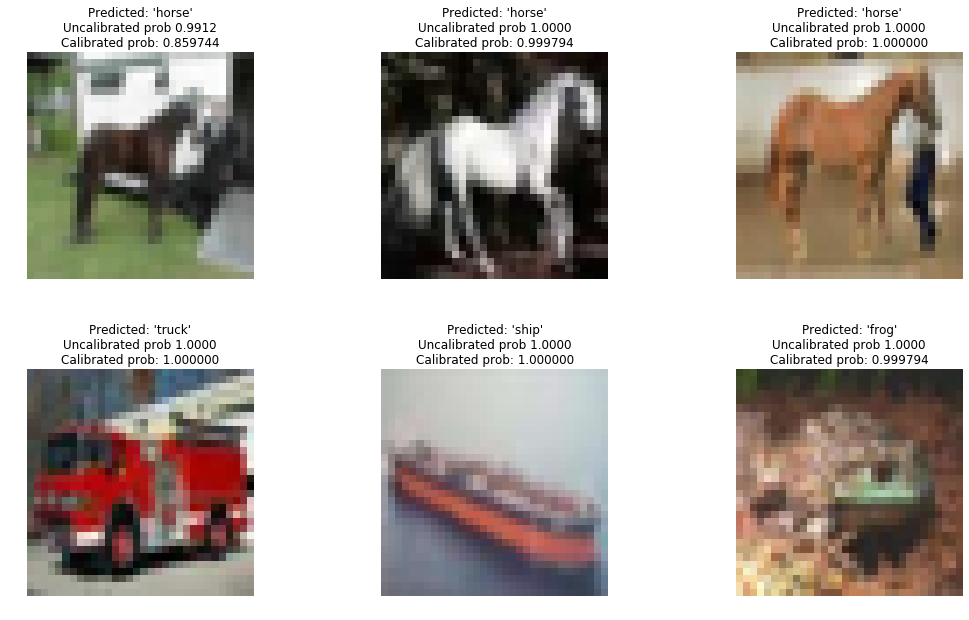

In [18]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4})


for i, idx in enumerate(idxs):
    test_ima = cifar10['test_images'][idx]/255.
    pred = np.argmax(probs[idx])
    ax_arr[i//3, i%3].imshow(test_ima)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted: '{}'\nUncalibrated prob {:.4f}\nCalibrated prob: {:4f}".format(ix2label[pred], probs[idx][pred], pav_probs[idx][pred]))
    
plt.show();

## Calibrate using Multiclass Logistic Regression

In [19]:
t0 = time.time()
mlr_cal = MLRCalibrator(logits.astype(np.float), y_test.astype(np.float))
print("MLR calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

MLR calibration fitted, elapsed time: 1.028s


In [20]:
mlr_probs = mlr_cal.predict(logits.astype(np.float))

mlr_nll = neg_log_likelihood(mlr_probs, y_test)
mlr_acc = accuracy(mlr_probs, y_test)

print("Negative log-likelihood after calibration with MLR: {:.3f}".format(mlr_nll))
print("Accuracy after calibration with MLR: {:.3f}".format(mlr_acc))

Negative log-likelihood after calibration with MLR: 0.197
Accuracy after calibration with MLR: 0.933


Effect on probabilities:

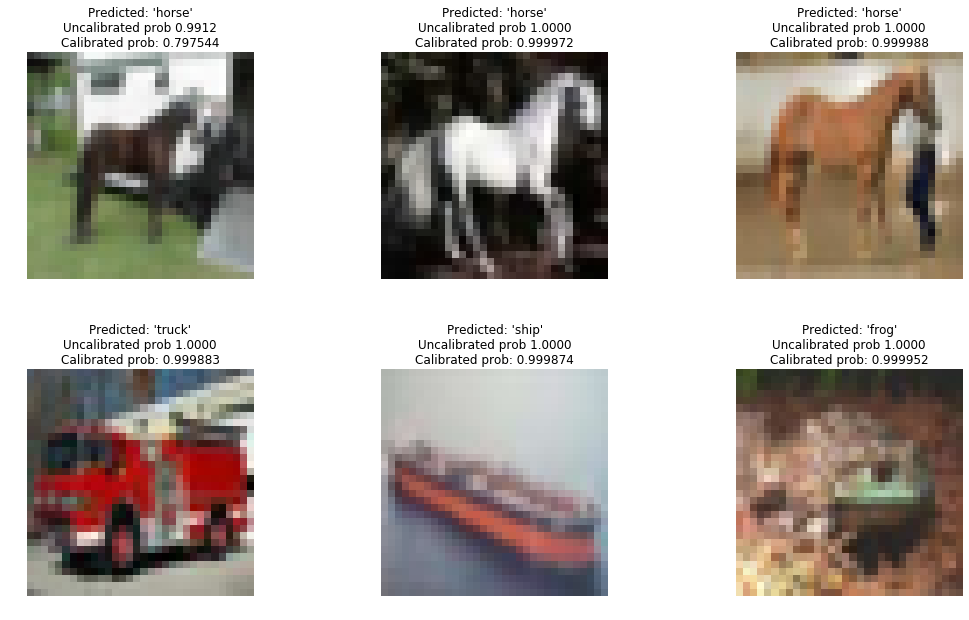

In [21]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4})


for i, idx in enumerate(idxs):
    test_ima = cifar10['test_images'][idx]/255.
    pred = np.argmax(probs[idx])
    ax_arr[i//3, i%3].imshow(test_ima)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted: '{}'\nUncalibrated prob {:.4f}\nCalibrated prob: {:4f}".format(ix2label[pred], probs[idx][pred], mlr_probs[idx][pred]))
    
plt.show();

## Calibrate using NICE-flow

Build flow:

In [22]:
t0 = time.time()
nice_cal = NiceCalibrator(logits.astype(np.float), y_test.astype(np.float), layers=4,
                          hidden_size=[10, 10, 10], epochs=1000, batch_size=100)
print("NICE-flow calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE-flow calibration fitted, elapsed time: 341.604s


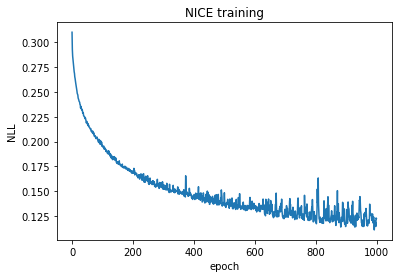

In [23]:
# Visalize training
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE training')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.show()

In [24]:
nice_probs = nice_cal.predict(logits)

nll_nice = neg_log_likelihood(nice_probs, y_test)
nice_acc = accuracy(nice_probs, y_test)

print("Negative log-likelihood after calibration with NICE: {:.3f}".format(nll_nice))
print("Accuracy after calibration with NICE: {:.3f}".format(nice_acc))

Negative log-likelihood after calibration with NICE: 0.112
Accuracy after calibration with NICE: 0.964


Effect on probabilities:

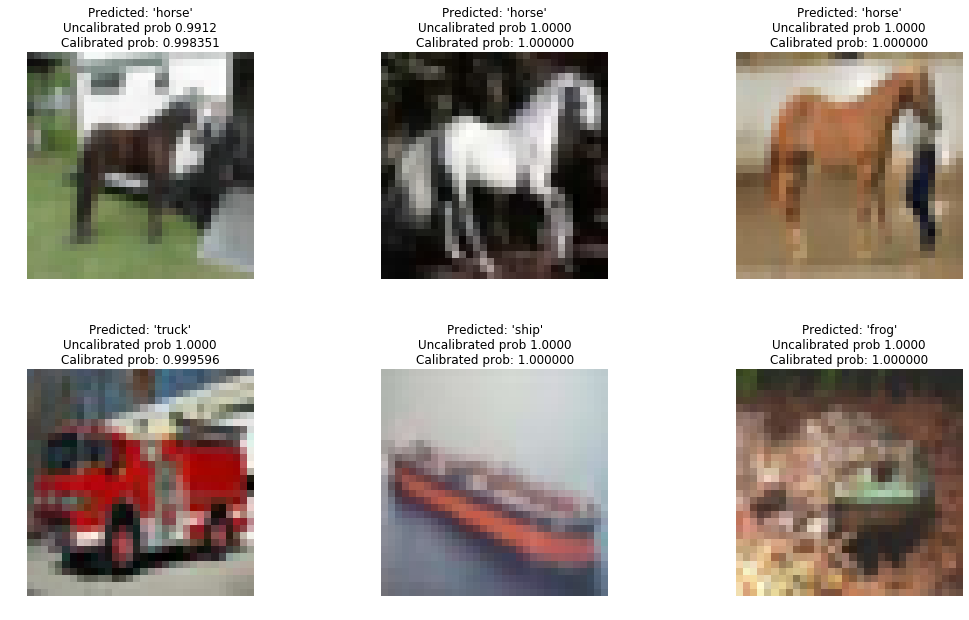

In [25]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4})


for i, idx in enumerate(idxs):
    test_ima = cifar10['test_images'][idx]/255.
    pred = np.argmax(probs[idx])
    ax_arr[i//3, i%3].imshow(test_ima)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted: '{}'\nUncalibrated prob {:.4f}\nCalibrated prob: {:4f}".format(ix2label[pred], probs[idx][pred], nice_probs[idx][pred]))
    
plt.show();

# Comparison of calibrators

Compare calibration on reliability plot:

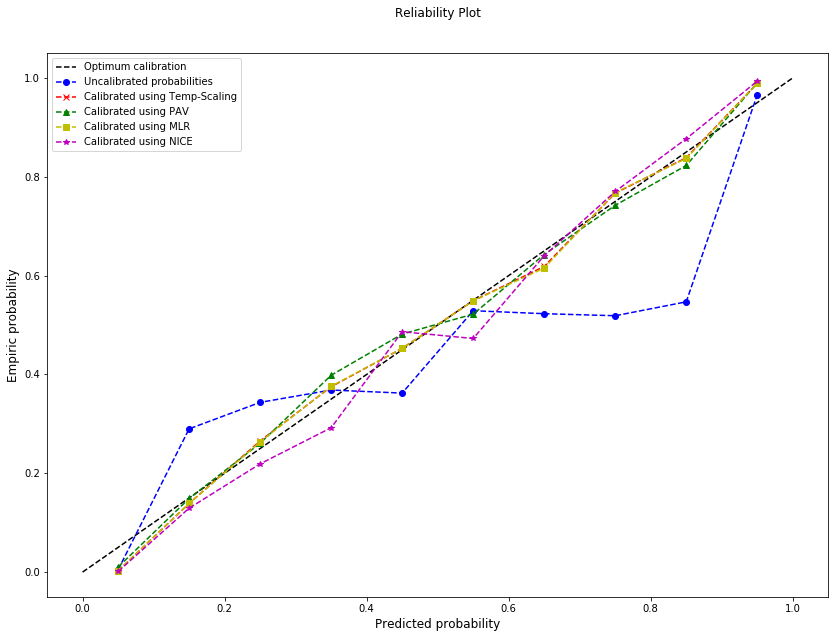

In [26]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = reliability_plot([probs, temp_probs, pav_probs, mlr_probs, nice_probs], y_test, ax=ax, bins=10, 
                                labels=['Uncalibrated probabilities', 'Calibrated using Temp-Scaling',
                                        'Calibrated using PAV', 'Calibrated using MLR', 'Calibrated using NICE']);

Empricial cross-entropy with flat prior for different classes:

In [27]:
priors = np.zeros(10) + 1/10.
log_lr = detection_log_likelihood_ratios(logits, priors)

lr = np.exp(log_lr)

In [39]:
ECE = empirical_cross_entropy(lr[:, 0], y_test[:, 0], 0.999)

In [40]:
ECE

0.07609263879855006

In [41]:
lr

array([[6.27623745e-23, 1.00322349e-16, 4.90891141e-12, ...,
        1.81035701e-20, 3.04629196e-17, 5.55991954e-24],
       [7.86242824e-16, 2.86919069e-11, 6.04397011e-23, ...,
        7.57181401e-23, 1.97189354e+13, 5.64814027e-17],
       [1.09246456e-03, 2.53228963e+00, 1.00742440e-08, ...,
        3.38421589e-11, 2.21392606e+02, 3.87272373e-05],
       ...,
       [4.77471370e-19, 7.39532793e-20, 5.60551478e-10, ...,
        9.24743724e-15, 3.08516425e-17, 6.57268878e-18],
       [2.59682461e-17, 6.77442634e+15, 9.09118631e-17, ...,
        2.06559689e-18, 2.14245993e-22, 2.40742494e-16],
       [3.88587103e-20, 1.02873598e-18, 3.93443937e-20, ...,
        1.27162435e+17, 4.18575032e-26, 1.39887743e-21]])